**PREAMBLE**

In [1]:
import pandas as pd
import numpy as np
import math

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

from scipy.cluster import hierarchy as hc
import scipy

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# import graph objects as "go"
import plotly.graph_objs as go
import plotly 

# For Partial Dependence Plots
from pdpbox import pdp
from plotnine import *

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline

<div class="alert alert-success">

# *LOADING THE DATA*
    
 

**Importing Data from CSV**

In [2]:
Main_Dataframe = pd.read_csv("Data/FUT_ML_cleaned_data.csv")  
Main_Dataframe = Main_Dataframe.drop('Unnamed: 0',axis=1)

In [3]:
Main_Dataframe

,overall,age,height,weight,intl_rep,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,...,def_workrate_Med,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020,ln_ps4_min,ln_ps4_max,ln_ps4_last,ln_avg_price
0,94,32,170,72.0,0.0,92.0,95.0,90.0,95.0,92.0,...,0,1,0,0,0,0,11.849398,14.808762,12.598115,13.329080
1,93,34,185,80.0,0.0,92.0,91.0,93.0,90.0,90.0,...,0,1,0,0,0,0,12.043554,14.978661,12.923912,13.511108
2,90,35,180,80.0,0.0,92.0,92.0,92.0,92.0,91.0,...,0,1,0,0,0,0,10.043249,13.017003,10.968198,11.530126
3,90,33,193,92.0,0.0,0.0,58.0,61.0,0.0,43.0,...,1,1,0,0,0,0,10.388995,13.304685,10.484306,11.846840
4,90,32,182,85.0,0.0,82.0,88.0,78.0,88.0,86.0,...,1,1,0,0,0,0,11.289782,14.220976,11.542484,12.755379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96438,87,20,178,68.0,0.0,81.0,79.0,81.0,83.0,85.0,...,1,0,0,0,0,1,10.126631,13.081541,12.185870,11.604086
96439,86,22,178,70.0,0.0,84.0,86.0,82.0,86.0,88.0,...,0,0,0,0,0,1,10.126631,13.081541,11.177453,11.604086
96440,85,20,178,73.0,0.0,90.0,92.0,87.0,88.0,98.0,...,1,0,0,0,0,1,9.615805,12.577636,11.561716,11.096721
96441,85,20,170,65.0,0.0,92.0,92.0,92.0,88.0,97.0,...,1,0,0,0,0,1,9.615805,12.577636,11.385092,11.096721


**We now try to further clean the dataset by replacing the current ages of the icons (which do not add value since their peak attributes are used) with an imputed value of their age.**


In [4]:
Main_Dataframe.loc[Main_Dataframe['age'] > 40, 'age_imputed'] = np.nan
Main_Dataframe.loc[Main_Dataframe['age'] <= 40, 'age_imputed'] = Main_Dataframe['age']

In [5]:
#Replace the NaN ages randomly using a distribution of the remaining ages
Main_Dataframe['age_imputed'] = Main_Dataframe.age_imputed.fillna(int(np.random.normal(28.97,4.08,1)))

# N.B: Mean and Standard deviation taken from the Main_Dataframe['age_imputed'].describe(). Assumed a normal distribution of the 
#      ages in our sample and imupted age is randomly selected from this distribution

In [6]:
Main_Dataframe['age'] = Main_Dataframe['age_imputed']
Main_Dataframe = Main_Dataframe.drop('age',axis=1)
Main_Dataframe.describe()

,overall,height,weight,intl_rep,pace,pace_acceleration,pace_sprint_speed,dribbling,drib_agility,drib_balance,...,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020,ln_ps4_min,ln_ps4_max,ln_ps4_last,ln_avg_price,age_imputed
count,96443.000000,96443.000000,96443.000000,96443.000000,96443.000000,96443.000000,96443.000000,96443.000000,96443.000000,96443.000000,...,96443.000000,96443.000000,96443.000000,96443.000000,96443.000000,96443.000000,96443.000000,96443.000000,96443.000000,96443.000000
mean,68.503251,181.394202,74.777983,0.949493,62.261429,66.416961,66.635889,57.825337,65.366600,64.801593,...,0.204805,0.208724,0.209823,0.189687,0.186960,5.645623,9.410865,6.664882,7.528244,27.783022
std,8.358415,6.734672,10.453511,0.735174,24.157336,15.175536,14.890294,22.655147,15.390584,14.635981,...,0.403561,0.406399,0.407185,0.392056,0.389882,1.270685,0.712020,1.657810,0.968167,4.529060
min,44.000000,155.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.605170,8.517193,5.298317,6.763914,17.000000
25%,63.000000,177.000000,70.000000,1.000000,59.000000,58.000000,59.000000,54.000000,57.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.010635,9.210340,5.298317,7.110488,24.000000
50%,68.000000,182.000000,75.000000,1.000000,69.000000,69.000000,69.000000,64.000000,68.000000,66.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.010635,9.210340,6.214608,7.110488,28.000000
75%,73.000000,186.000000,80.000000,1.000000,77.000000,77.000000,77.000000,71.000000,76.000000,75.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.703782,9.210340,7.244228,7.457061,31.000000
max,99.000000,208.000000,110.000000,5.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,14.100690,16.523561,16.432906,15.312125,40.000000


In [7]:
#Creating a smaller random sample of the Main Dataframe
x=Main_Dataframe.sample(5000)

<div class="alert alert-success">

# *Functions*
    
 

**1) Simple Function to calculate the error metric (Root Mean Standard Error)** *Taken from the fast.ai Notebook*

In [8]:
# The Baseline error metric is Root Mean Square Error
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

**2) Function for the Random Forest Process** *Doc strings will be added later for documentation*

In [9]:
# Our Customized Random Forest Function
def randomforest_customized(input_dataframe,y,list_drop,split_ratio=0.25,fi=False,fi_hist=False,fi_threshold=0.01,datasets_return=False,oob = False):
    
# STEP 1: GET THE LIST OF FEATURES AND THE TARGET LABEL:
    # Labels are the values we want to predict
    labels = input_dataframe[y]
    
    list_drop.append(y)
    
    # Remove the labels from the features
    features = input_dataframe.drop(list_drop,axis=1)

    # Saving feature names for later use
    feature_list = features.columns.tolist()

# STEP 2: SPLIT THE DATASET:
    # Split the data into training and testing sets: The answer to life, universe and everything
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = split_ratio, random_state = 42) 
    
    #For validation of the shape size
    print('Training Features Shape :', train_features.shape)
    print('Training Labels Shape   :', train_labels.shape)
    print('Testing Features Shape  :', test_features.shape)
    print('Testing Labels Shape    :', test_labels.shape)
    print('')
    
# STEP 3: RUN THE PREDICTIONS:
    # Initiate Random Forest Regressor (with or without the OOB as requested)
    if oob == True:
        rf = RandomForestRegressor(max_depth=3,oob_score = True)
    else:
        rf = RandomForestRegressor()
        
    # Train the model on training data by fitting
    %time rf.fit(train_features, train_labels)

    # Use the forest's predict method on the test data
    predictions_basic_model = rf.predict(test_features)

# STEP 4: CALCULATE THE METRICS SCORES:
    #Print the Metrics by datatype
    rmse_train      = rmse(rf.predict(train_features), train_labels)
    rmse_validation = rmse(rf.predict(test_features), test_labels)
    r2_train        = rf.score(train_features, train_labels) 
    r2_validation   = rf.score(test_features, test_labels)
    
    if oob == True:
        oob_stat = rf.oob_score_
    else:
        oob_stat = 'Not Reported' 
    
    print('')
    print('RMSE Training Data   :',rmse_train)
    print('RMSE Validation Data :',rmse_validation)
    print('R^2 Training Data    :',r2_train)
    print('R^2 Validation Data  :',r2_validation)
    print('Out-of-Bag Score     :',oob_stat)
    
# STEP 5: REPORT FEATURE IMPORTANCE (IF CALLED) AND PRINT THOSE ABOVE THE THRESHOLD:
    # Get numerical feature importances
    importances = list(rf.feature_importances_)
    
    if fi == True:
        print('')
        print('FEATURE IMPORTANCES')
        print
        
        # List of tuples with variable and importance
        feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
                     
        # Extract some of the  most important features
        important_features = [feature_tuple for feature_tuple in feature_importances if (feature_tuple[1] >= fi_threshold)]
        
        # Store the feature importances in a single list
        important_features_list_all = [feature_tuple[0] for feature_tuple in feature_importances if feature_tuple[1]] 
        
        # List of Important Features (as a function of threshold)
        important_features_list_major = [feature_tuple[0] for feature_tuple in feature_importances if feature_tuple[1] > 0.0090] 
        

        # Print out the feature and importances 
        [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in important_features]
        
    else:
        pass

# STEP 5.1: PLOT FEATURE IMPORTANCE HISTOGRAM (IF CALLED):
    if fi_hist == True:

        # Set the style
        plt.style.use('fivethirtyeight')                 # Requires matplotlib.pyplot to be installed

        # list of x locations for plotting
        x_values = range(len(importances))

        # Make a bar chart
        plt.bar(x_values, importances, orientation = 'vertical')

        # Tick labels for x axis
        plt.xticks(x_values, feature_list, rotation='vertical')

        # Axis labels and title
        plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
  
    else:
        pass

# STEP 6: RETURNING RESULTS:    
    model = rf
    
    # STEP 6.1: SOME POST ESTIMATION OUTPUTS THAT CAN BE USED FOR ANALYSIS:
    imp_features = dict({'All_Feats':important_features_list_all,
                         'Imp_Feats':important_features_list_major})

    
    # STEP 6.2: THE MODEL DATASETS AS SPLIT THAT CAN BE USED FOR ANALYSIS:
    dataset_requested = dict({'Train_Feats':train_features, 
                              'Test_Feats':test_features, 
                              'Train_Labels':train_labels,
                              'Test_Labels':test_labels})

    rf_output_dict = {'Model':model}
    
    if fi == True:
        rf_output_dict.update(imp_features)
    else:
        pass

    if datasets_return == True:
        rf_output_dict.update(dataset_requested)
    else:
        pass
 
    return rf_output_dict

**Running our first Random Forest Regressor**

Training Features Shape : (3750, 85)
Training Labels Shape   : (3750,)
Testing Features Shape  : (1250, 85)
Testing Labels Shape    : (1250,)

CPU times: user 1.84 s, sys: 31.2 ms, total: 1.88 s
Wall time: 1.86 s

RMSE Training Data   : 1.071800163148713
RMSE Validation Data : 1.0388761964191786
R^2 Training Data    : 0.5465482669582289
R^2 Validation Data  : 0.5693766737000043
Out-of-Bag Score     : 0.5317389259973881

FEATURE IMPORTANCES
Variable: overall              Importance: 0.921
Variable: drib_composure       Importance: 0.0441


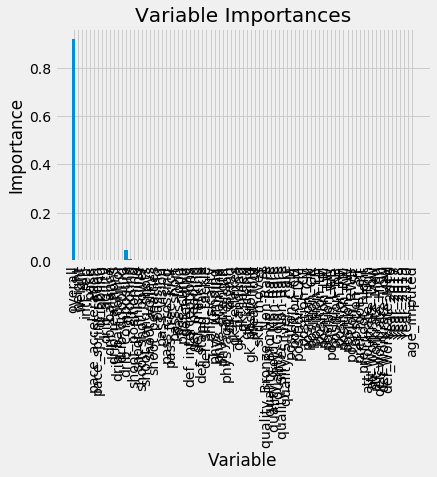

In [10]:
#RUN ONLY ONCE, THEN COMMENT OUT SINCE AN INSTANCE TAKES ABOUT 5-7 MINS

model_1 = randomforest_customized(input_dataframe=x, #Substitute x with Main_Dataframe when running final model
                                 y='ln_ps4_last',
                                 list_drop=['ln_ps4_min','ln_ps4_max','ln_avg_price'],
                                 split_ratio=0.25,
                                 fi=True,
                                 fi_hist=True,
                                 datasets_return=True,
                                 oob=True)

<div class="alert alert-success">
    
**Even a simple machine thus seems to substantially better both in terms of prediction as well as fit!**

<div class="alert alert-warning"> 
    
**However we see a massive discrepency between the Training Dataset and Testing Dataset Predictions. What could explain this?**

<div class="alert alert-warning"> 
    
# DATA DISTRIBUTION: Outliers!

**Removing the Outliers**

In [11]:
minimum_value = 10000
cutoff = math.log(minimum_value,math.e)
Main_Dataframe_Outliers = Main_Dataframe[Main_Dataframe['ln_ps4_last']>cutoff]

**Running the Random Forest for this subset of Outliers**

Training Features Shape : (6119, 85)
Training Labels Shape   : (6119,)
Testing Features Shape  : (2040, 85)
Testing Labels Shape    : (2040,)

CPU times: user 2.56 s, sys: 0 ns, total: 2.56 s
Wall time: 2.57 s

RMSE Training Data   : 0.7704590129794967
RMSE Validation Data : 0.7733905896671953
R^2 Training Data    : 0.6135129960258978
R^2 Validation Data  : 0.6233361092102899
Out-of-Bag Score     : 0.6017600393207843

FEATURE IMPORTANCES
Variable: overall              Importance: 0.9144
Variable: intl_rep             Importance: 0.0093
Variable: pace                 Importance: 0.0097
Variable: pace_sprint_speed    Importance: 0.0107
Variable: Year_2020            Importance: 0.0403


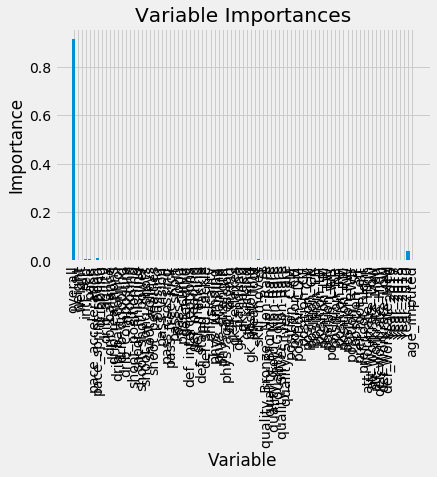

In [12]:
model_Outliers = randomforest_customized(input_dataframe=Main_Dataframe_Outliers,
                                                       y='ln_ps4_last',
                                               list_drop=['ln_ps4_min','ln_ps4_max','ln_avg_price'],
                                             split_ratio=0.25,
                                                     fi = True,
                                                 fi_hist=True,
                                            fi_threshold=0.009,
                                                     oob=True)

<div class="alert alert-success">
    
#### The discrepency has vanished. The Machine Now does even better both in terms of prediction as well as fit! 

<div class="alert alert-success">

*Thus for immediate purposes, instead of building a general model, we restrict our attention to the valuable players auction. This is also more interesting, since we see the most fluctuation and these auction attract the most attention of FUT players*

<div class="alert alert-info" role="info">

# **SECOND MODEL**: USING ONLY THE "IMPORTANT FEATURES"

In [13]:
target_label = ['ln_ps4_last']
important_features = model_Outliers['Imp_Feats'] + target_label

In [14]:
Main_Dataframe_Outliers_Model_2 = Main_Dataframe_Outliers.loc[:,important_features]

Training Features Shape : (6119, 5)
Training Labels Shape   : (6119,)
Testing Features Shape  : (2040, 5)
Testing Labels Shape    : (2040,)

CPU times: user 344 ms, sys: 0 ns, total: 344 ms
Wall time: 365 ms

RMSE Training Data   : 0.7711650218443281
RMSE Validation Data : 0.7731728779271723
R^2 Training Data    : 0.6128043580185605
R^2 Validation Data  : 0.6235481433621339
Out-of-Bag Score     : 0.6013307816581732

FEATURE IMPORTANCES
Variable: overall              Importance: 0.9187
Variable: intl_rep             Importance: 0.0119
Variable: pace                 Importance: 0.0141
Variable: pace_sprint_speed    Importance: 0.0115
Variable: Year_2020            Importance: 0.0438


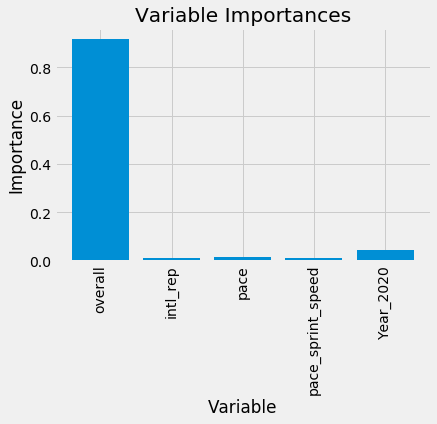

In [15]:
model_2 =randomforest_customized(input_dataframe=Main_Dataframe_Outliers_Model_2,
                                               y='ln_ps4_last',
                                       list_drop=[],
                                     split_ratio=0.25,
                                              fi=True,
                                         fi_hist=True,
                                            fi_threshold=0.01,
                                             oob=True)

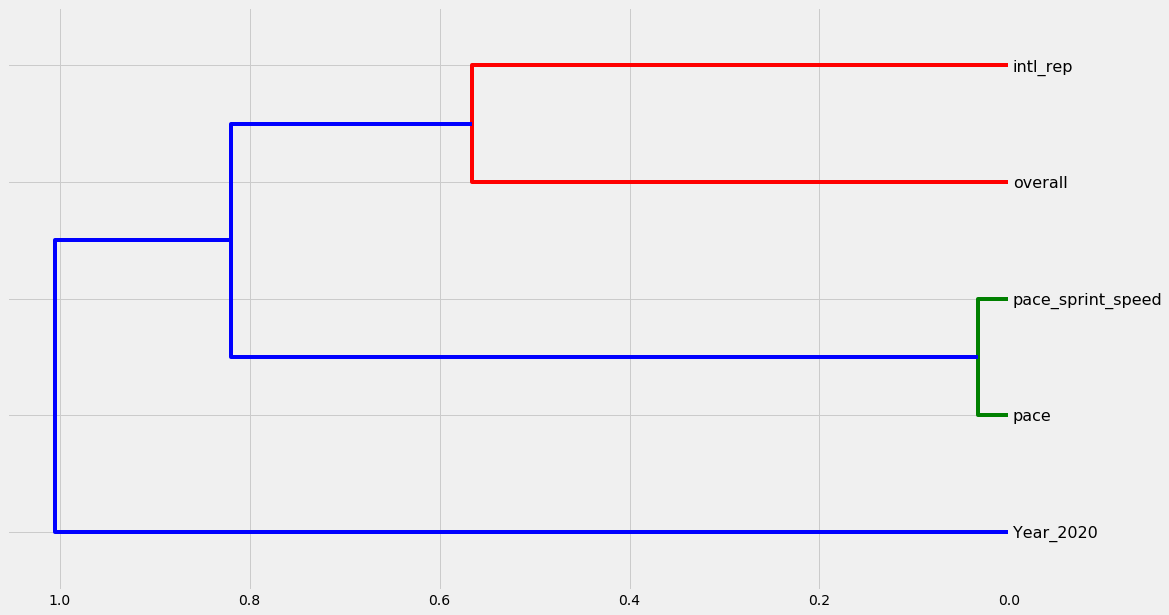

In [16]:
Main_Dataframe_Outliers_Model_2 = Main_Dataframe_Outliers_Model_2.drop('ln_ps4_last',axis=1)
corr = np.round(scipy.stats.spearmanr(Main_Dataframe_Outliers_Model_2).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=Main_Dataframe_Outliers_Model_2.columns, orientation='left', leaf_font_size=16)
plt.show()

<div class="alert alert-info" role="info">

# **THIRD MODEL**: BY REDUCING "SIMILAR" CLUSTERS


In [17]:
# Always ensure the cluster_list contains the target label(s)
cluster_list = ['ln_ps4_last',
                'overall','pace_acceleration','age_imputed','phys_stamina','intl_rep','drib_composure']

Main_Dataframe_Outliers_Model_3 = Main_Dataframe_Outliers.loc[:,cluster_list]
Main_Dataframe_Outliers_Model_3

,ln_ps4_last,overall,pace_acceleration,age_imputed,phys_stamina,intl_rep,drib_composure
0,12.598115,94,95.0,32.0,76.0,0.0,0.0
1,12.923912,93,91.0,34.0,87.0,0.0,0.0
2,10.968198,90,92.0,35.0,76.0,0.0,0.0
3,10.484306,90,58.0,33.0,44.0,0.0,0.0
4,11.542484,90,88.0,32.0,86.0,0.0,0.0
...,...,...,...,...,...,...,...
96438,12.185870,87,79.0,20.0,87.0,0.0,91.0
96439,11.177453,86,86.0,22.0,86.0,0.0,87.0
96440,11.561716,85,92.0,20.0,95.0,0.0,90.0
96441,11.385092,85,92.0,20.0,79.0,0.0,82.0


Training Features Shape : (6119, 6)
Training Labels Shape   : (6119,)
Testing Features Shape  : (2040, 6)
Testing Labels Shape    : (2040,)

CPU times: user 422 ms, sys: 0 ns, total: 422 ms
Wall time: 429 ms

RMSE Training Data   : 0.7856454969997131
RMSE Validation Data : 0.7919705625119652
R^2 Training Data    : 0.5981267804220237
R^2 Validation Data  : 0.6050207328269757
Out-of-Bag Score     : 0.5870987948509125

FEATURE IMPORTANCES
Variable: overall              Importance: 0.9382
Variable: pace_acceleration    Importance: 0.039
Variable: intl_rep             Importance: 0.0173


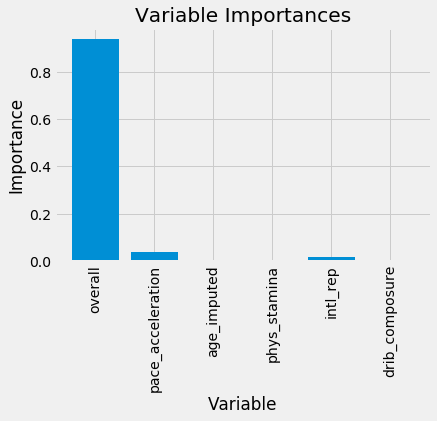

In [18]:
model_3 =randomforest_customized(input_dataframe=Main_Dataframe_Outliers_Model_3,
                                    y='ln_ps4_last',
                                    list_drop=[],
                                    split_ratio=0.25,
                                    fi=True,
                                    fi_hist=True,
                                    datasets_return=True,
                                    oob=True)

<div class="alert alert-success" role="success">

# **RF INTERPRETATION**


**From our analysis so far, the following 5 features seem to be the most important:** 
                
                1.Overall 
                2.Age Imputed
                3.Pace_Acceleration
                4.Intl_Rep
                5.Physical_Stamina

**But what are their trends and is it possible they proxying for something else?**

<div class="alert alert-info" role="info">

## **UNCONDITIONAL GG-PLOTS**


**GG Plots give us the reduced form relationship between our two variables.**

In [19]:
# Choosing a random sample from our Main Outliers Dataset
x_all = Main_Dataframe_Outliers.sample(1000)

*We first look at the relationship between the most important feature &mdash; a card's* **Overall** &mdash; *and* **Log Prices**

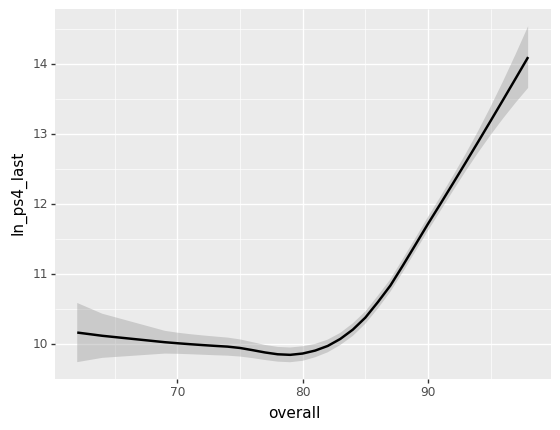

<ggplot: (8735229698165)>

In [20]:
ggplot(x_all, aes('overall', 'ln_ps4_last'))+stat_smooth(se=True, method='loess')

### *Interesting Trend:*
**Prices are non-monotonic with Overall Quality**: Indeed we see that ln prices actually dip a little as player's quality improves from the mid-70s to the early 80s
    
**Possible Explanation**: *More players rising in overall from 70s to mid-80s may see a fall in other desirable attributes: Pace?*
    

*We next look at the relationship between the most important feature trait &mdash; a card's* **Pace_Acceleration** &mdash; *and* **Log Prices**

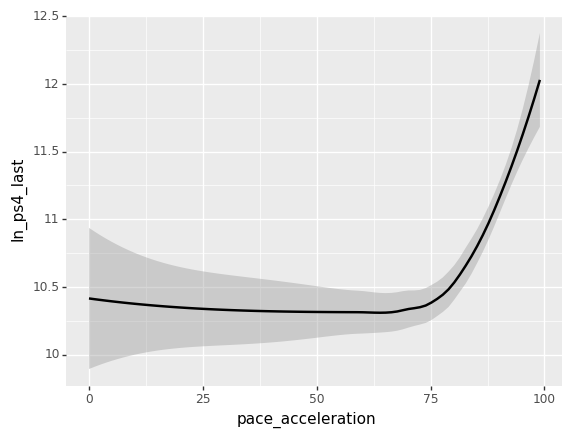

<ggplot: (8735221371013)>

In [21]:
ggplot(x_all, aes('pace_acceleration','ln_ps4_last'))+stat_smooth(se=True, method='loess')

**Observation**: *We see that (for relevant rage pace_accleration > 25), Log Price monotonically increases with an increase in pace_acceleration, suggesting this is a crucial trait*


*The natural question subsequently is what is the relationship between* **pace_acceleration** and **overall**:

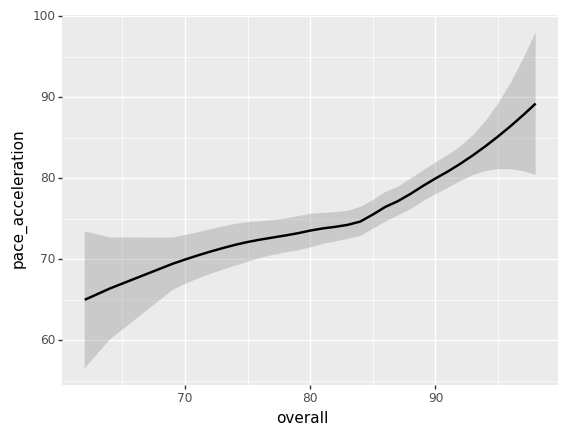

<ggplot: (8735224338233)>

In [22]:
ggplot(x_all, aes('overall','pace_acceleration'))+stat_smooth(se=True, method='loess')

**No evidence to claim that pace is falling with a rise in overall from mid-70s to 80s** \
    -Alternative Explanation: Is it possible that older players are likelier to have a higher overall, since they develop other characteristics?
    

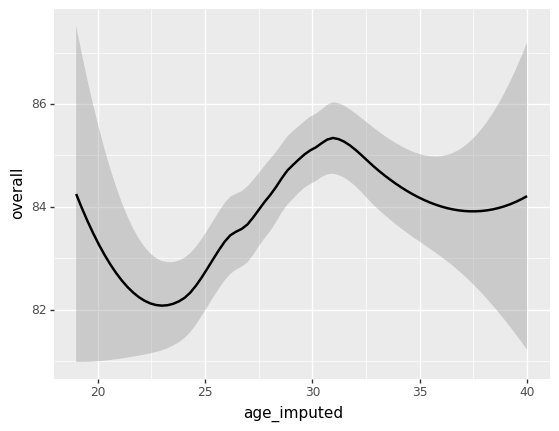

<ggplot: (8735221300429)>

In [23]:
ggplot(x_all, aes('age_imputed','overall'))+stat_smooth(se=True, method='loess')

** We see that* **Overall Quality** seems to rise with **(Imputed) Age** in our desired range**

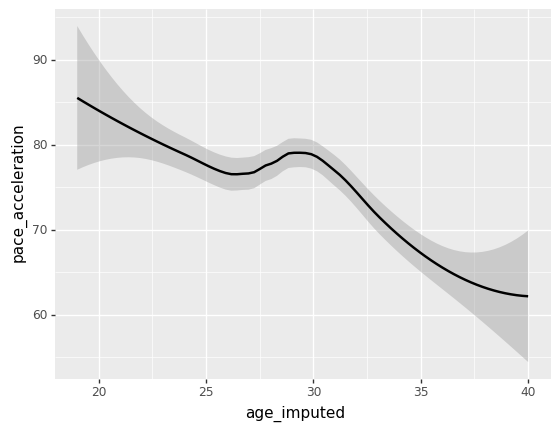

<ggplot: (8735229723989)>

In [24]:
ggplot(x_all, aes('age_imputed','pace_acceleration'))+stat_smooth(se=True, method='loess')

**This seems to show that pace rapidly declines with age, suggesting that this might be a potential channel for explanation**

<div class="alert alert-info" role="info">

## **PARTIAL DEPENDENCE PLOTS**


**To add robustness to this hypothesis, let us attempt to plot some Partial Dependence Plots (PDPs)**

In [25]:
def plot_pdp(feat,chosen_model,chosen_data, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(model=chosen_model['Model'],
                        dataset=chosen_data,
                        model_features=chosen_data.columns,
                        feature=feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

*We first sample from our training data*

In [26]:
training_sample = model_3['Train_Feats'].sample(1000)
training_sample

,overall,pace_acceleration,age_imputed,phys_stamina,intl_rep,drib_composure
60597,88,62.0,30.0,75.0,3.0,85.0
57294,81,58.0,33.0,34.0,1.0,56.0
15827,96,97.0,32.0,79.0,0.0,0.0
74909,86,66.0,20.0,76.0,2.0,79.0
57581,86,90.0,22.0,82.0,2.0,86.0
...,...,...,...,...,...,...
57808,86,89.0,28.0,96.0,2.0,89.0
72932,64,67.0,22.0,62.0,1.0,55.0
78063,82,87.0,32.0,82.0,3.0,79.0
13840,82,50.0,31.0,45.0,0.0,0.0


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1d445c4d90>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1d3c27ea10>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


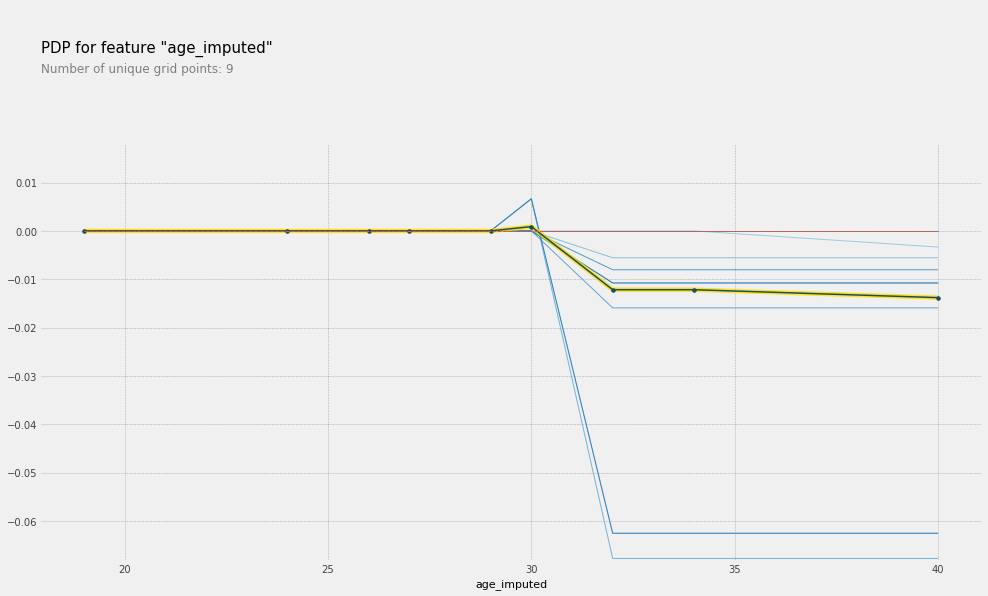

In [27]:
plot_pdp('age_imputed',model_3,training_sample,clusters=10)

**We find that age does NOT really affect prices.** *(The concentrated bump near 28-29 could be potentially due to the fact that the usually pricey Icons were randomly alloted ages using a normal distribution with mean 28.9 and an approximate sd 4)**

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1d3c45b610>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1d44538350>})

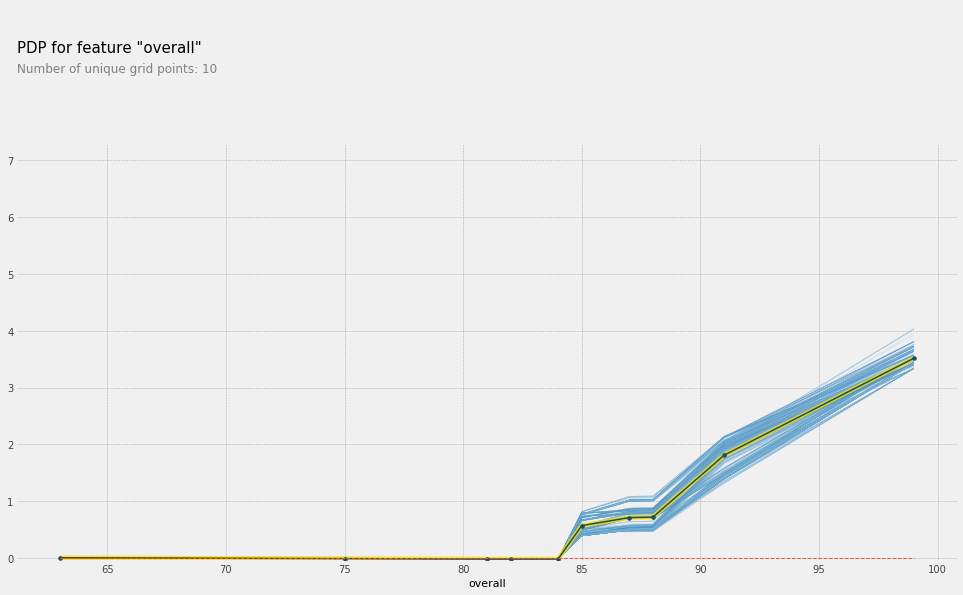

In [28]:
plot_pdp('overall',model_3,training_sample)

*We find that overall does hold a non-decreasing weakly monotonic realtionship with log prices.* **Therefore, ceteris paribus, Overall quality does not negatively really affect prices.**

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1d10e7e7d0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1d10ef1bd0>})

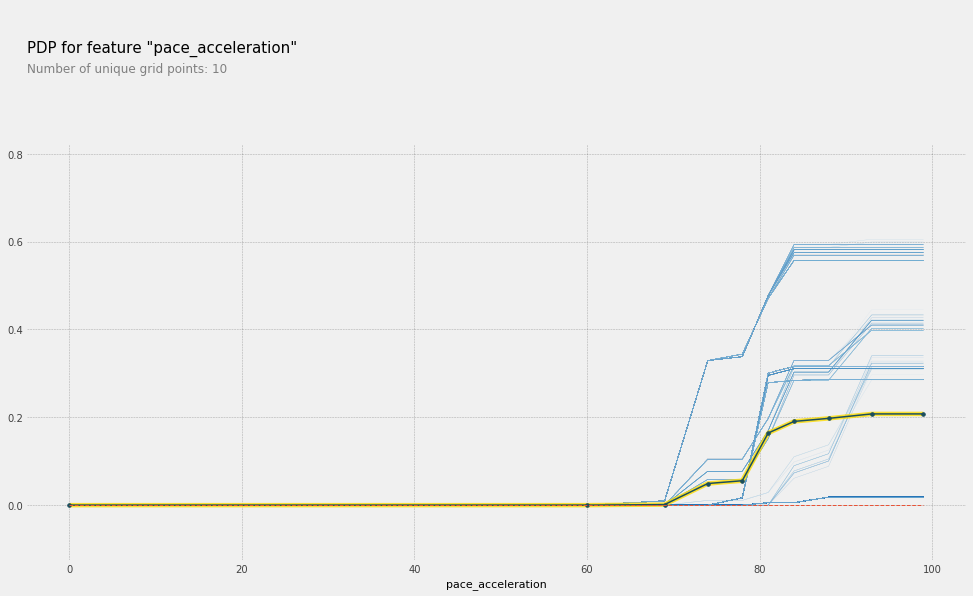

In [29]:
plot_pdp('pace_acceleration',model_3,training_sample)

**Pace (for the range of interest) seems to hold an non-decreasing and weakly monotic relationship with log prices**

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

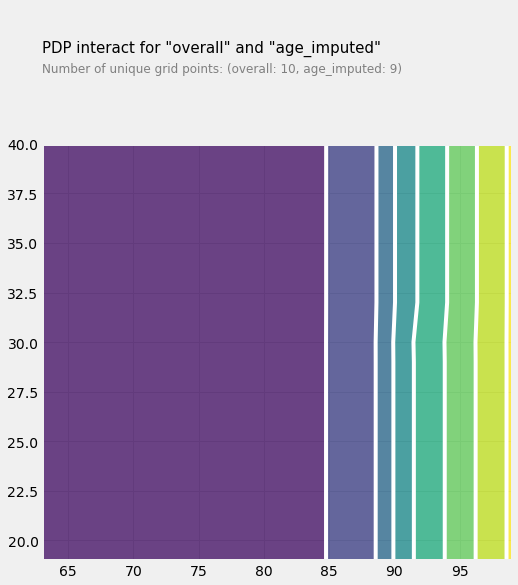

In [30]:
feats = ['overall', 'age_imputed']
p = pdp.pdp_interact(model_3['Model'], training_sample , training_sample.columns,feats)
pdp.pdp_interact_plot(p, feats)

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

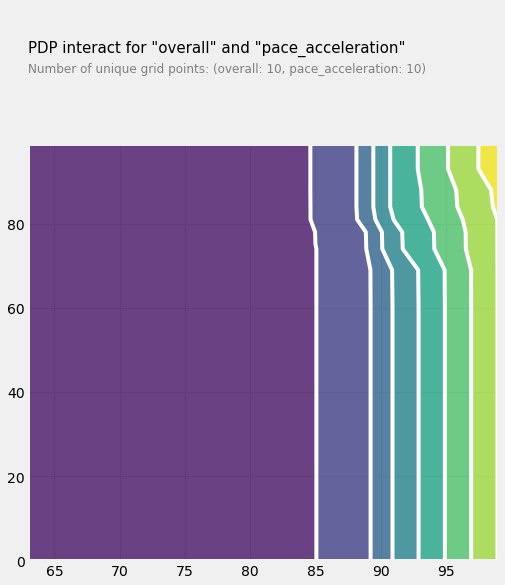

In [31]:
feats = ['overall', 'pace_acceleration']
p = pdp.pdp_interact(model_3['Model'], training_sample , training_sample.columns,feats)
pdp.pdp_interact_plot(p, feats)

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

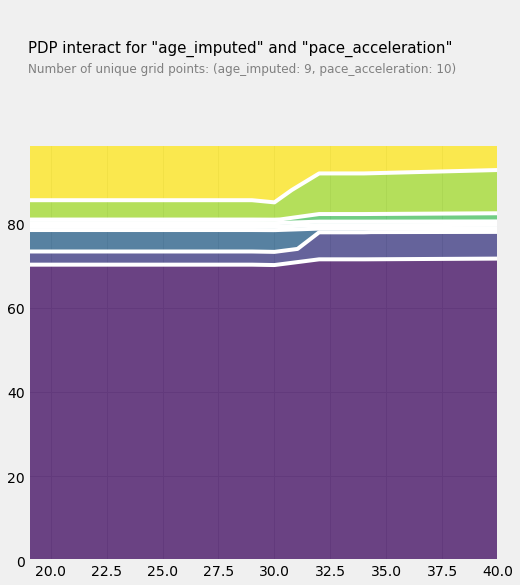

In [32]:
feats = ['age_imputed', 'pace_acceleration']
p = pdp.pdp_interact(model_3['Model'], training_sample , training_sample.columns,feats)
pdp.pdp_interact_plot(p, feats)

**Focusing on the region with pace_acceleration above 40 (few players among the elite have pace below 40), and ignoring the narrow age range in the middle (due to the imputation reasons discussed earlier), we note the following the points:** 
1. **Age** and **Pace_acceleration** do not seem to interact in many ways substantially most of the time, as pace is more important factor
2. However, the interaction does seem to be substantial in the case where a player is both old AND slow, in which case the prices actually are the lowest




In [ ]:
Main_Dataframe_Outliers['pace_acceleration'].describe()

<div class="alert alert-success" role="success">

# **Conclusion**


**Our Final Model is thus:**

Training Features Shape : (6119, 6)
Training Labels Shape   : (6119,)
Testing Features Shape  : (2040, 6)
Testing Labels Shape    : (2040,)

CPU times: user 1.34 s, sys: 31.2 ms, total: 1.38 s
Wall time: 1.35 s

RMSE Training Data   : 0.23484209982308202
RMSE Validation Data : 0.5867662002223992
R^2 Training Data    : 0.9640922886990525
R^2 Validation Data  : 0.7831864605214548
Out-of-Bag Score     : Not Reported

FEATURE IMPORTANCES
Variable: overall              Importance: 0.5785
Variable: pace_acceleration    Importance: 0.0947
Variable: age_imputed          Importance: 0.1091
Variable: phys_stamina         Importance: 0.0732
Variable: intl_rep             Importance: 0.0826
Variable: drib_composure       Importance: 0.0618


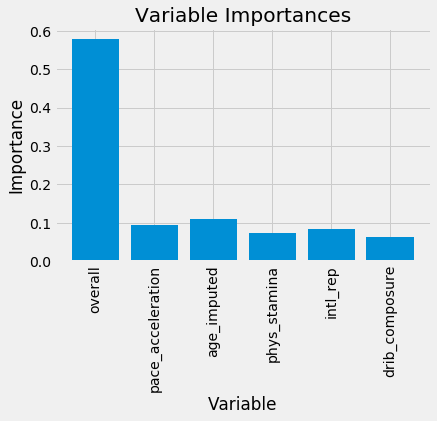

In [51]:
model_3 =randomforest_customized(input_dataframe=Main_Dataframe_Outliers_Model_3,
                                    y='ln_ps4_last',
                                    list_drop=[],
                                    split_ratio=0.25,
                                    fi=True,
                                    fi_hist=True,
                                    datasets_return=True)